# Training on SAE Sparse Features

Loss factor of 0.01, working with the 25 highest activating features per digit

Cosine instead of MSE for auxilary loss - it seemed to work quite well, and makes auxiliary loss easier to manage w/global loss.

In [1]:
import time

EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 256
L1_PENALTY = 0.01
N = 25

## Imports

In [3]:
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
from graph_helpers import (plot_weights,
                    plot_activations,
                    plot_losses,
                    plot_saliency_map,
                    plot_sparse_vecs_by_image,
                    plot_top_act_images_by_feature,
                    feature_inversion
                )

In [5]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, load_intermediate_labels

## Set Device to GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [7]:
# train data
train_images = load_intermediate_labels("first_layer/train_images.pkl")
train_labels = load_intermediate_labels("first_layer/train_labels.pkl")

# val data
val_images = load_intermediate_labels("first_layer/val_images.pkl")
val_labels = load_intermediate_labels("first_layer/val_labels.pkl")

# test data
test_images = load_intermediate_labels("first_layer/test_images.pkl")
test_labels = load_intermediate_labels("first_layer/test_labels.pkl")

# intermediate labels
recon_max_sparse_act_one = load_intermediate_labels(f"first_layer/train_images_recon_max_sparse_top_{N}.pkl")
recon_max_sparse_act_one_ablated = load_intermediate_labels(f"first_layer/train_images_recon_max_sparse_ablated_top_{N}.pkl")

v2_recon_max_sparse_act_one = load_intermediate_labels(f"first_layer/recon_max_sparse_top_{N}_v2.pkl")
v2_recon_max_sparse_act_one_ablated = load_intermediate_labels(f"first_layer/recon_max_sparse_ablated_top_{N}_v2.pkl")

In [8]:
type(recon_max_sparse_act_one[0])

torch.Tensor

In [9]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

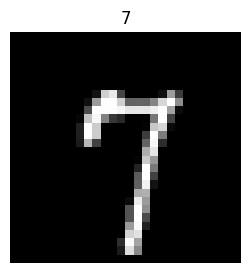

In [10]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

### SAE

In [12]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

## Dataloader

In [13]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, first_layer_acts=None, v2_first_layer_acts=None):
        self.images = images
        self.labels = labels
        self.first_layer_acts = first_layer_acts
        self.v2_first_layer_acts = v2_first_layer_acts

    def __len__(self):
        assert len(self.images) == len(self.labels)
        if self.first_layer_acts:
            assert(len(self.first_layer_acts) == len(self.images))
            
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx].copy()).float()
        label = torch.tensor(self.labels[idx].copy(), dtype=torch.long)

        if self.first_layer_acts:
            return (image, label, self.first_layer_acts[idx], self.v2_first_layer_acts[idx])
        else:
            return (image, label)

In [14]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Training Loop

In [15]:
min_loss = 0.0
max_loss = 0.025
step = 0.005

loss_factor_one = 0.011
loss_factors = np.arange(min_loss, max_loss + step, step)
print(len(loss_factors))

6


In [16]:
loss_data_dict = {}
for loss_factor in loss_factors:
    print("#" * 50)
    print(f"Loss factor: {loss_factor}\n\n")
    ######################################################################################################
    # MODELS INIT
    ######################################################################################################
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    model = NeuralNetwork().to(device)
    
    # loss functions
    classification_loss_fn = nn.CrossEntropyLoss()
    hidden_act_one_loss_fn = nn.CosineSimilarity()
    
    # optimizers
    optimizer = torch.optim.Adam(model.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())
    
    ######################################################################################################
    # DATA INIT
    ######################################################################################################
    
    generator = torch.Generator().manual_seed(seed)
    
    NUM_WORKERS = 4
    if device.type.lower() == "cpu":
        NUM_WORKERS = 0
    
    # training data
    train_dataset = EdgeDataset(train_images, train_labels, recon_max_sparse_act_one, v2_recon_max_sparse_act_one)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)
    
    # validation data
    val_dataset = EdgeDataset(val_images, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation
    
    # test data
    test_dataset = EdgeDataset(test_images, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)
    
    ######################################################################################################
    # TRAINING LOOP
    ######################################################################################################
    best_model = None
    best_sae_one = None
    best_sae_two = None
    num_epochs = 20
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    
    validation_losses = []
    training_losses = []
    SAE_hidden_one_losses = []
    SAE_hidden_two_losses = []
    
    # Initialize storage for training features and labels
    feature_activations_one_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    feature_activations_two_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    labels_train = torch.zeros(len(train_loader.dataset), dtype=torch.long)
    
    for epoch in range(num_epochs):
        if epoch < 10:
            loss_factor_one = 0.006
            loss_factor_two = 0
        else:
            loss_factor_one = 0
            loss_factor_two = loss_factor
        
        # --- Training Phase ---
        model.train()  # set the model to training mode - this is currently a no-op
        sae_hidden_two.train()
        sae_hidden_one.train()
        
        train_loss = 0.0
        total_sae_loss_hidden_two = 0.0
        total_sae_loss_hidden_one = 0.0
    
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
        for batch_idx, batch in enumerate(train_bar):
            # deconstruct batch items
            images, labels, acts_one, v2_acts_one = batch
            images, labels, acts_one, v2_acts_one = images.to(device), labels.to(device), acts_one.to(device), v2_acts_one.to(device)
            
            # forward pass
            classification_out, hidden_act_one, hidden_act_two = model(images)
    
            # Classification loss and backprop
            optimizer.zero_grad()
            
            sub_loss = (1 - hidden_act_one_loss_fn(hidden_act_one, acts_one)).mean()
            sub_loss_two = (1 - hidden_act_one_loss_fn(hidden_act_one, v2_acts_one)).mean()
            total_loss = classification_loss_fn(classification_out, labels) + loss_factor_one * (sub_loss) + loss_factor_two * (sub_loss_two)
            total_loss.backward()
            
            optimizer.step()
            train_loss += total_loss.item()
            train_bar.set_postfix(loss=total_loss.item())
    
            # to prevent backprop on both graphs:
            hidden_act_one_detached = hidden_act_one.detach()
            hidden_act_two_detached = hidden_act_two.detach()
    
            # SAE loss and backprop - hidden layer one
            optimizer_sae_hidden_one.zero_grad()
            reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
            sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                      reconstructed_one,
                                                      encoded_one,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_one.backward()
            optimizer_sae_hidden_one.step()
            total_sae_loss_hidden_one += sae_loss_hidden_one.item()
            
            # SAE loss and backprop - hidden layer two
            optimizer_sae_hidden_two.zero_grad()
            reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
            sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                      reconstructed_two,
                                                      encoded_two,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_two.backward()
            optimizer_sae_hidden_two.step()
            total_sae_loss_hidden_two += sae_loss_hidden_two.item()
    
            # Store training features and labels
            start_idx = batch_idx * train_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_train[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_train[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_train[start_idx:end_idx] = labels.cpu()
    
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for batch in val_bar:
                # deconstruct
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
    
                # forward pass
                classification_out, _, _ = model(images)
    
                # compute loss
                loss = classification_loss_fn(classification_out, labels)
    
                # calculate metrics
                val_loss += loss.item()
                _, predicted = torch.max(classification_out, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    
        # epoch stats
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
        avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)
        val_accuracy = 100 * correct / total
    
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
        print(f"  SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    
        model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_val_loss = avg_val_loss  # Update loss for reference
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
            
        # Optional: Save if accuracy is equal but loss is lower
        elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
    
        validation_losses.append(avg_val_loss)
        training_losses.append(avg_train_loss)
        SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
        SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)
    
    Z_train_one = feature_activations_one_train.detach().T.numpy()
    Z_train_two = feature_activations_two_train.detach().T.numpy()
    y_train = labels_train.numpy()
    
    
    ######################################################################################################
    # EVAL
    ######################################################################################################
    best_model.eval()  # again currently a no-op
    best_sae_one.eval()
    best_sae_two.eval()
    
    test_correct = 0
    test_total = 0
    
    feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    labels_test = torch.zeros(len(test_images), dtype=torch.long)
    
    recon_errors_one = []
    recon_errors_two = []
    
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f"Evaluation")
        for i, batch in enumerate(test_bar):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
    
            # forward pass
            classification_out, hidden_one_act, hidden_two_act = best_model(images)
            reconstructed_one, encoded_one = best_sae_one(hidden_one_act)
            reconstructed_two, encoded_two = best_sae_two(hidden_two_act)
    
            # SAE reconstruction
            recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
            recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())
    
            start_idx = i * test_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_test[start_idx:end_idx] = labels.cpu()
    
            # stats
            _, predicted = torch.max(classification_out, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    Z_test_one = feature_activations_one_test.T.numpy()
    Z_test_two = feature_activations_two_test.T.numpy()
    y_test = labels_test.numpy()
    
    test_accuracy = 100 * test_correct / test_total
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    
    # reconstruction accuracy of SAE at each layer
    avg_recon_error_one = np.mean(recon_errors_one)
    avg_recon_error_two = np.mean(recon_errors_two)
    print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
    print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")
    
    # Compute sparsity (average non-zero features per image)
    sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
    sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
    print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
    print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")
    
    ######################################################################################################
    # SPARSE FEATURE PROBES
    ######################################################################################################
        
    clf_one = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_one.fit(Z_train_one, y_train)
    acc_one = clf_one.score(Z_test_one, y_test)
    print(f"Linear Probe Accuracy (Hidden One): {acc_one:.2%}")
    
    clf_two = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_two.fit(Z_train_two, y_train)
    acc_two = clf_two.score(Z_test_two, y_test)
    print(f"Linear Probe Accuracy (Hidden Two): {acc_two:.2%}")

    loss_data_dict[(loss_factor_one, loss_factor_two)] = {}
    loss_data_dict[(loss_factor_one, loss_factor_two)]["Final_Accuracy"] = test_accuracy
    loss_data_dict[(loss_factor_one, loss_factor_two)]["Final_Loss"] = avg_train_loss
    loss_data_dict[(loss_factor_one, loss_factor_two)]["S1_Probe_Acccuracy"] = acc_one
    loss_data_dict[(loss_factor_one, loss_factor_two)]["S2_Probe_Acccuracy"] = acc_two
    loss_data_dict[(loss_factor_one, loss_factor_two)]["Loss_Plot_Data"] = (validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses)

    del feature_activations_one_train, feature_activations_two_train, labels_train
    del feature_activations_one_test, feature_activations_two_test, labels_test
    del best_model, best_sae_one, best_sae_two
    del validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses
    del clf_two, clf_one
    del model, sae_hidden_one, sae_hidden_two
    del train_dataset, train_loader
    del test_dataset, test_loader
    del val_dataset, val_loader
    torch.cuda.empty_cache()
    print()

##################################################
Loss factor: 0.0




Epoch 1/20
  Train Loss: 1.0078
  SAE Train Loss (hidden one): 8.9391
  SAE Train Loss (hidden two): 1.1738
  Val Loss: 0.4736 | Val Acc: 85.84%
  Saved model with Val Acc: 85.84%


Epoch 2/20
  Train Loss: 0.4240
  SAE Train Loss (hidden one): 0.5181
  SAE Train Loss (hidden two): 0.1015
  Val Loss: 0.3982 | Val Acc: 88.56%
  Saved model with Val Acc: 88.56%


Epoch 3/20
  Train Loss: 0.3567
  SAE Train Loss (hidden one): 0.6195
  SAE Train Loss (hidden two): 0.1075
  Val Loss: 0.3707 | Val Acc: 89.40%
  Saved model with Val Acc: 89.40%


Epoch 4/20
  Train Loss: 0.3336
  SAE Train Loss (hidden one): 0.5939
  SAE Train Loss (hidden two): 0.0951
  Val Loss: 0.3685 | Val Acc: 88.81%


Epoch 5/20
  Train Loss: 0.3178
  SAE Train Loss (hidden one): 0.6918
  SAE Train Loss (hidden two): 0.0891
  Val Loss: 0.3412 | Val Acc: 90.04%
  Saved model with Val Acc: 90.04%


Epoch 6/20
  Train Loss: 0.3076
  SAE Train Loss (hidden one): 0.6375
  SAE Train Loss (hidden two): 0.0874
  Val Loss: 0.3467 | Val Acc: 89.90%


Epoch 7/20
  Train Loss: 0.3007
  SAE Train Loss (hidden one): 0.6408
  SAE Train Loss (hidden two): 0.0818
  Val Loss: 0.3272 | Val Acc: 90.55%
  Saved model with Val Acc: 90.55%


Epoch 8/20
  Train Loss: 0.2954
  SAE Train Loss (hidden one): 0.6296
  SAE Train Loss (hidden two): 0.0802
  Val Loss: 0.3090 | Val Acc: 91.23%
  Saved model with Val Acc: 91.23%


Epoch 9/20
  Train Loss: 0.2862
  SAE Train Loss (hidden one): 0.6328
  SAE Train Loss (hidden two): 0.0766
  Val Loss: 0.3374 | Val Acc: 90.20%


Epoch 10/20
  Train Loss: 0.2839
  SAE Train Loss (hidden one): 0.6290
  SAE Train Loss (hidden two): 0.0709
  Val Loss: 0.3103 | Val Acc: 90.99%


Epoch 11/20
  Train Loss: 0.2720
  SAE Train Loss (hidden one): 0.6137
  SAE Train Loss (hidden two): 0.0687
  Val Loss: 0.3088 | Val Acc: 90.91%


Epoch 12/20
  Train Loss: 0.2699
  SAE Train Loss (hidden one): 0.7195
  SAE Train Loss (hidden two): 0.0695
  Val Loss: 0.3076 | Val Acc: 91.07%


Epoch 13/20
  Train Loss: 0.2666
  SAE Train Loss (hidden one): 0.6530
  SAE Train Loss (hidden two): 0.0639
  Val Loss: 0.2934 | Val Acc: 91.36%
  Saved model with Val Acc: 91.36%


Epoch 14/20
  Train Loss: 0.2619
  SAE Train Loss (hidden one): 0.6615
  SAE Train Loss (hidden two): 0.0619
  Val Loss: 0.3131 | Val Acc: 90.97%


Epoch 15/20
  Train Loss: 0.2575
  SAE Train Loss (hidden one): 0.7007
  SAE Train Loss (hidden two): 0.0612
  Val Loss: 0.3062 | Val Acc: 91.23%


Epoch 16/20
  Train Loss: 0.2587
  SAE Train Loss (hidden one): 0.6387
  SAE Train Loss (hidden two): 0.0585
  Val Loss: 0.3092 | Val Acc: 91.11%


Epoch 17/20
  Train Loss: 0.2537
  SAE Train Loss (hidden one): 0.7345
  SAE Train Loss (hidden two): 0.0564
  Val Loss: 0.2981 | Val Acc: 91.31%


Epoch 18/20
  Train Loss: 0.2544
  SAE Train Loss (hidden one): 0.6995
  SAE Train Loss (hidden two): 0.0543
  Val Loss: 0.2910 | Val Acc: 91.58%
  Saved model with Val Acc: 91.58%


Epoch 19/20
  Train Loss: 0.2495
  SAE Train Loss (hidden one): 0.7969
  SAE Train Loss (hidden two): 0.0537
  Val Loss: 0.2922 | Val Acc: 91.73%
  Saved model with Val Acc: 91.73%


Epoch 20/20
  Train Loss: 0.2472
  SAE Train Loss (hidden one): 0.6610
  SAE Train Loss (hidden two): 0.0531
  Val Loss: 0.3063 | Val Acc: 91.39%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 299.85it/s]

Final Test Accuracy: 92.07%
Average Reconstruction Error (Hidden One): 0.2274
Average Reconstruction Error (Hidden Two): 0.0102
Average Non-Zero Features per Image (Hidden One): 33.38
Average Non-Zero Features per Image (Hidden Two): 35.10



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.34%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.16%

##################################################
Loss factor: 0.005




Epoch 1/20
  Train Loss: 1.0078
  SAE Train Loss (hidden one): 8.9391
  SAE Train Loss (hidden two): 1.1738
  Val Loss: 0.4736 | Val Acc: 85.84%
  Saved model with Val Acc: 85.84%


Epoch 2/20
  Train Loss: 0.4240
  SAE Train Loss (hidden one): 0.5181
  SAE Train Loss (hidden two): 0.1015
  Val Loss: 0.3982 | Val Acc: 88.56%
  Saved model with Val Acc: 88.56%


Epoch 3/20
  Train Loss: 0.3567
  SAE Train Loss (hidden one): 0.6195
  SAE Train Loss (hidden two): 0.1075
  Val Loss: 0.3707 | Val Acc: 89.40%
  Saved model with Val Acc: 89.40%


Epoch 4/20
  Train Loss: 0.3336
  SAE Train Loss (hidden one): 0.5939
  SAE Train Loss (hidden two): 0.0951
  Val Loss: 0.3685 | Val Acc: 88.81%


Epoch 5/20
  Train Loss: 0.3178
  SAE Train Loss (hidden one): 0.6918
  SAE Train Loss (hidden two): 0.0891
  Val Loss: 0.3412 | Val Acc: 90.04%
  Saved model with Val Acc: 90.04%


Epoch 6/20
  Train Loss: 0.3076
  SAE Train Loss (hidden one): 0.6375
  SAE Train Loss (hidden two): 0.0874
  Val Loss: 0.3467 | Val Acc: 89.90%


Epoch 7/20
  Train Loss: 0.3007
  SAE Train Loss (hidden one): 0.6408
  SAE Train Loss (hidden two): 0.0818
  Val Loss: 0.3272 | Val Acc: 90.55%
  Saved model with Val Acc: 90.55%


Epoch 8/20
  Train Loss: 0.2954
  SAE Train Loss (hidden one): 0.6296
  SAE Train Loss (hidden two): 0.0802
  Val Loss: 0.3090 | Val Acc: 91.23%
  Saved model with Val Acc: 91.23%


Epoch 9/20
  Train Loss: 0.2862
  SAE Train Loss (hidden one): 0.6328
  SAE Train Loss (hidden two): 0.0766
  Val Loss: 0.3374 | Val Acc: 90.20%


Epoch 10/20
  Train Loss: 0.2839
  SAE Train Loss (hidden one): 0.6290
  SAE Train Loss (hidden two): 0.0709
  Val Loss: 0.3103 | Val Acc: 90.99%


Epoch 11/20
  Train Loss: 0.2770
  SAE Train Loss (hidden one): 0.6153
  SAE Train Loss (hidden two): 0.0693
  Val Loss: 0.3068 | Val Acc: 90.89%


Epoch 12/20
  Train Loss: 0.2743
  SAE Train Loss (hidden one): 0.7116
  SAE Train Loss (hidden two): 0.0699
  Val Loss: 0.3022 | Val Acc: 91.30%
  Saved model with Val Acc: 91.30%


Epoch 13/20
  Train Loss: 0.2713
  SAE Train Loss (hidden one): 0.6686
  SAE Train Loss (hidden two): 0.0653
  Val Loss: 0.2920 | Val Acc: 91.39%
  Saved model with Val Acc: 91.39%


Epoch 14/20
  Train Loss: 0.2659
  SAE Train Loss (hidden one): 0.6586
  SAE Train Loss (hidden two): 0.0634
  Val Loss: 0.3092 | Val Acc: 91.01%


Epoch 15/20
  Train Loss: 0.2628
  SAE Train Loss (hidden one): 0.7231
  SAE Train Loss (hidden two): 0.0609
  Val Loss: 0.3084 | Val Acc: 91.20%


Epoch 16/20
  Train Loss: 0.2630
  SAE Train Loss (hidden one): 0.6696
  SAE Train Loss (hidden two): 0.0593
  Val Loss: 0.3093 | Val Acc: 91.15%


Epoch 17/20
  Train Loss: 0.2562
  SAE Train Loss (hidden one): 0.7106
  SAE Train Loss (hidden two): 0.0570
  Val Loss: 0.2999 | Val Acc: 91.31%


Epoch 18/20
  Train Loss: 0.2589
  SAE Train Loss (hidden one): 0.7246
  SAE Train Loss (hidden two): 0.0579
  Val Loss: 0.2885 | Val Acc: 91.66%
  Saved model with Val Acc: 91.66%


Epoch 19/20
  Train Loss: 0.2535
  SAE Train Loss (hidden one): 0.7901
  SAE Train Loss (hidden two): 0.0548
  Val Loss: 0.2922 | Val Acc: 91.65%


Epoch 20/20
  Train Loss: 0.2501
  SAE Train Loss (hidden one): 0.7236
  SAE Train Loss (hidden two): 0.0542
  Val Loss: 0.3035 | Val Acc: 91.43%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 309.37it/s]


Final Test Accuracy: 92.04%
Average Reconstruction Error (Hidden One): 0.9331
Average Reconstruction Error (Hidden Two): 0.0162
Average Non-Zero Features per Image (Hidden One): 33.52
Average Non-Zero Features per Image (Hidden Two): 35.78


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.37%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.48%

##################################################
Loss factor: 0.01




Epoch 1/20
  Train Loss: 1.0078
  SAE Train Loss (hidden one): 8.9391
  SAE Train Loss (hidden two): 1.1738
  Val Loss: 0.4736 | Val Acc: 85.84%
  Saved model with Val Acc: 85.84%


Epoch 2/20
  Train Loss: 0.4240
  SAE Train Loss (hidden one): 0.5181
  SAE Train Loss (hidden two): 0.1015
  Val Loss: 0.3982 | Val Acc: 88.56%
  Saved model with Val Acc: 88.56%


Epoch 3/20
  Train Loss: 0.3567
  SAE Train Loss (hidden one): 0.6195
  SAE Train Loss (hidden two): 0.1075
  Val Loss: 0.3707 | Val Acc: 89.40%
  Saved model with Val Acc: 89.40%


Epoch 4/20
  Train Loss: 0.3336
  SAE Train Loss (hidden one): 0.5939
  SAE Train Loss (hidden two): 0.0951
  Val Loss: 0.3685 | Val Acc: 88.81%


Epoch 5/20
  Train Loss: 0.3178
  SAE Train Loss (hidden one): 0.6918
  SAE Train Loss (hidden two): 0.0891
  Val Loss: 0.3412 | Val Acc: 90.04%
  Saved model with Val Acc: 90.04%


Epoch 6/20
  Train Loss: 0.3076
  SAE Train Loss (hidden one): 0.6375
  SAE Train Loss (hidden two): 0.0874
  Val Loss: 0.3467 | Val Acc: 89.90%


Epoch 7/20
  Train Loss: 0.3007
  SAE Train Loss (hidden one): 0.6408
  SAE Train Loss (hidden two): 0.0818
  Val Loss: 0.3272 | Val Acc: 90.55%
  Saved model with Val Acc: 90.55%


Epoch 8/20
  Train Loss: 0.2954
  SAE Train Loss (hidden one): 0.6296
  SAE Train Loss (hidden two): 0.0802
  Val Loss: 0.3090 | Val Acc: 91.23%
  Saved model with Val Acc: 91.23%


Epoch 9/20
  Train Loss: 0.2862
  SAE Train Loss (hidden one): 0.6328
  SAE Train Loss (hidden two): 0.0766
  Val Loss: 0.3374 | Val Acc: 90.20%


Epoch 10/20
  Train Loss: 0.2839
  SAE Train Loss (hidden one): 0.6290
  SAE Train Loss (hidden two): 0.0709
  Val Loss: 0.3103 | Val Acc: 90.99%


Epoch 11/20
  Train Loss: 0.2807
  SAE Train Loss (hidden one): 0.6330
  SAE Train Loss (hidden two): 0.0687
  Val Loss: 0.3048 | Val Acc: 90.88%


Epoch 12/20
  Train Loss: 0.2773
  SAE Train Loss (hidden one): 0.7150
  SAE Train Loss (hidden two): 0.0691
  Val Loss: 0.3038 | Val Acc: 91.21%


Epoch 13/20
  Train Loss: 0.2748
  SAE Train Loss (hidden one): 0.6081
  SAE Train Loss (hidden two): 0.0644
  Val Loss: 0.2951 | Val Acc: 91.28%
  Saved model with Val Acc: 91.28%


Epoch 14/20
  Train Loss: 0.2709
  SAE Train Loss (hidden one): 0.6623
  SAE Train Loss (hidden two): 0.0626
  Val Loss: 0.3118 | Val Acc: 91.12%


Epoch 15/20
  Train Loss: 0.2670
  SAE Train Loss (hidden one): 0.6702
  SAE Train Loss (hidden two): 0.0614
  Val Loss: 0.3097 | Val Acc: 91.20%


Epoch 16/20
  Train Loss: 0.2666
  SAE Train Loss (hidden one): 0.7488
  SAE Train Loss (hidden two): 0.0592
  Val Loss: 0.3046 | Val Acc: 91.18%


Epoch 17/20
  Train Loss: 0.2599
  SAE Train Loss (hidden one): 0.6920
  SAE Train Loss (hidden two): 0.0570
  Val Loss: 0.3040 | Val Acc: 91.10%


Epoch 18/20
  Train Loss: 0.2619
  SAE Train Loss (hidden one): 0.7104
  SAE Train Loss (hidden two): 0.0565
  Val Loss: 0.2949 | Val Acc: 91.32%
  Saved model with Val Acc: 91.32%


Epoch 19/20
  Train Loss: 0.2575
  SAE Train Loss (hidden one): 0.7297
  SAE Train Loss (hidden two): 0.0551
  Val Loss: 0.2922 | Val Acc: 91.49%
  Saved model with Val Acc: 91.49%


Epoch 20/20
  Train Loss: 0.2554
  SAE Train Loss (hidden one): 0.7583
  SAE Train Loss (hidden two): 0.0523
  Val Loss: 0.3066 | Val Acc: 91.27%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 290.23it/s]

Final Test Accuracy: 91.87%
Average Reconstruction Error (Hidden One): 0.2639
Average Reconstruction Error (Hidden Two): 0.0126
Average Non-Zero Features per Image (Hidden One): 33.33
Average Non-Zero Features per Image (Hidden Two): 35.15



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.08%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.15%

##################################################
Loss factor: 0.015




Epoch 1/20
  Train Loss: 1.0078
  SAE Train Loss (hidden one): 8.9391
  SAE Train Loss (hidden two): 1.1738
  Val Loss: 0.4736 | Val Acc: 85.84%
  Saved model with Val Acc: 85.84%


Epoch 2/20
  Train Loss: 0.4240
  SAE Train Loss (hidden one): 0.5181
  SAE Train Loss (hidden two): 0.1015
  Val Loss: 0.3982 | Val Acc: 88.56%
  Saved model with Val Acc: 88.56%


Epoch 3/20
  Train Loss: 0.3567
  SAE Train Loss (hidden one): 0.6195
  SAE Train Loss (hidden two): 0.1075
  Val Loss: 0.3707 | Val Acc: 89.40%
  Saved model with Val Acc: 89.40%


Epoch 4/20
  Train Loss: 0.3336
  SAE Train Loss (hidden one): 0.5939
  SAE Train Loss (hidden two): 0.0951
  Val Loss: 0.3685 | Val Acc: 88.81%


Epoch 5/20
  Train Loss: 0.3178
  SAE Train Loss (hidden one): 0.6918
  SAE Train Loss (hidden two): 0.0891
  Val Loss: 0.3412 | Val Acc: 90.04%
  Saved model with Val Acc: 90.04%


Epoch 6/20
  Train Loss: 0.3076
  SAE Train Loss (hidden one): 0.6375
  SAE Train Loss (hidden two): 0.0874
  Val Loss: 0.3467 | Val Acc: 89.90%


Epoch 7/20
  Train Loss: 0.3007
  SAE Train Loss (hidden one): 0.6408
  SAE Train Loss (hidden two): 0.0818
  Val Loss: 0.3272 | Val Acc: 90.55%
  Saved model with Val Acc: 90.55%


Epoch 8/20
  Train Loss: 0.2954
  SAE Train Loss (hidden one): 0.6296
  SAE Train Loss (hidden two): 0.0802
  Val Loss: 0.3090 | Val Acc: 91.23%
  Saved model with Val Acc: 91.23%


Epoch 9/20
  Train Loss: 0.2862
  SAE Train Loss (hidden one): 0.6328
  SAE Train Loss (hidden two): 0.0766
  Val Loss: 0.3374 | Val Acc: 90.20%


Epoch 10/20
  Train Loss: 0.2839
  SAE Train Loss (hidden one): 0.6290
  SAE Train Loss (hidden two): 0.0709
  Val Loss: 0.3103 | Val Acc: 90.99%


Epoch 11/20
  Train Loss: 0.2850
  SAE Train Loss (hidden one): 0.6178
  SAE Train Loss (hidden two): 0.0682
  Val Loss: 0.3050 | Val Acc: 90.99%


Epoch 12/20
  Train Loss: 0.2814
  SAE Train Loss (hidden one): 0.6898
  SAE Train Loss (hidden two): 0.0685
  Val Loss: 0.3092 | Val Acc: 91.00%


Epoch 13/20
  Train Loss: 0.2800
  SAE Train Loss (hidden one): 0.6710
  SAE Train Loss (hidden two): 0.0646
  Val Loss: 0.2949 | Val Acc: 91.22%


Epoch 14/20
  Train Loss: 0.2735
  SAE Train Loss (hidden one): 0.6557
  SAE Train Loss (hidden two): 0.0621
  Val Loss: 0.3116 | Val Acc: 91.00%


Epoch 15/20
  Train Loss: 0.2697
  SAE Train Loss (hidden one): 0.6821
  SAE Train Loss (hidden two): 0.0618
  Val Loss: 0.3132 | Val Acc: 91.25%
  Saved model with Val Acc: 91.25%


Epoch 16/20
  Train Loss: 0.2720
  SAE Train Loss (hidden one): 0.7351
  SAE Train Loss (hidden two): 0.0590
  Val Loss: 0.3119 | Val Acc: 91.00%


Epoch 17/20
  Train Loss: 0.2643
  SAE Train Loss (hidden one): 0.6537
  SAE Train Loss (hidden two): 0.0560
  Val Loss: 0.3040 | Val Acc: 91.11%


Epoch 18/20
  Train Loss: 0.2664
  SAE Train Loss (hidden one): 0.7159
  SAE Train Loss (hidden two): 0.0569
  Val Loss: 0.2953 | Val Acc: 91.35%
  Saved model with Val Acc: 91.35%


Epoch 19/20
  Train Loss: 0.2635
  SAE Train Loss (hidden one): 0.8028
  SAE Train Loss (hidden two): 0.0561
  Val Loss: 0.2853 | Val Acc: 91.72%
  Saved model with Val Acc: 91.72%


Epoch 20/20
  Train Loss: 0.2603
  SAE Train Loss (hidden one): 0.8350
  SAE Train Loss (hidden two): 0.0519
  Val Loss: 0.3085 | Val Acc: 91.02%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 271.37it/s]


Final Test Accuracy: 92.17%
Average Reconstruction Error (Hidden One): 0.2504
Average Reconstruction Error (Hidden Two): 0.0101
Average Non-Zero Features per Image (Hidden One): 33.39
Average Non-Zero Features per Image (Hidden Two): 35.14


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.23%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.24%

##################################################
Loss factor: 0.02




Epoch 1/20
  Train Loss: 1.0078
  SAE Train Loss (hidden one): 8.9391
  SAE Train Loss (hidden two): 1.1738
  Val Loss: 0.4736 | Val Acc: 85.84%
  Saved model with Val Acc: 85.84%


Epoch 2/20
  Train Loss: 0.4240
  SAE Train Loss (hidden one): 0.5181
  SAE Train Loss (hidden two): 0.1015
  Val Loss: 0.3982 | Val Acc: 88.56%
  Saved model with Val Acc: 88.56%


Epoch 3/20
  Train Loss: 0.3567
  SAE Train Loss (hidden one): 0.6195
  SAE Train Loss (hidden two): 0.1075
  Val Loss: 0.3707 | Val Acc: 89.40%
  Saved model with Val Acc: 89.40%


Epoch 4/20
  Train Loss: 0.3336
  SAE Train Loss (hidden one): 0.5939
  SAE Train Loss (hidden two): 0.0951
  Val Loss: 0.3685 | Val Acc: 88.81%


Epoch 5/20
  Train Loss: 0.3178
  SAE Train Loss (hidden one): 0.6918
  SAE Train Loss (hidden two): 0.0891
  Val Loss: 0.3412 | Val Acc: 90.04%
  Saved model with Val Acc: 90.04%


Epoch 6/20
  Train Loss: 0.3076
  SAE Train Loss (hidden one): 0.6375
  SAE Train Loss (hidden two): 0.0874
  Val Loss: 0.3467 | Val Acc: 89.90%


Epoch 7/20
  Train Loss: 0.3007
  SAE Train Loss (hidden one): 0.6408
  SAE Train Loss (hidden two): 0.0818
  Val Loss: 0.3272 | Val Acc: 90.55%
  Saved model with Val Acc: 90.55%


Epoch 8/20
  Train Loss: 0.2954
  SAE Train Loss (hidden one): 0.6296
  SAE Train Loss (hidden two): 0.0802
  Val Loss: 0.3090 | Val Acc: 91.23%
  Saved model with Val Acc: 91.23%


Epoch 9/20
  Train Loss: 0.2862
  SAE Train Loss (hidden one): 0.6328
  SAE Train Loss (hidden two): 0.0766
  Val Loss: 0.3374 | Val Acc: 90.20%


Epoch 10/20
  Train Loss: 0.2839
  SAE Train Loss (hidden one): 0.6290
  SAE Train Loss (hidden two): 0.0709
  Val Loss: 0.3103 | Val Acc: 90.99%


Epoch 11/20
  Train Loss: 0.2894
  SAE Train Loss (hidden one): 0.6317
  SAE Train Loss (hidden two): 0.0685
  Val Loss: 0.3047 | Val Acc: 91.04%


Epoch 12/20
  Train Loss: 0.2866
  SAE Train Loss (hidden one): 0.6873
  SAE Train Loss (hidden two): 0.0692
  Val Loss: 0.3066 | Val Acc: 91.10%


Epoch 13/20
  Train Loss: 0.2836
  SAE Train Loss (hidden one): 0.6658
  SAE Train Loss (hidden two): 0.0646
  Val Loss: 0.2920 | Val Acc: 91.43%
  Saved model with Val Acc: 91.43%


Epoch 14/20
  Train Loss: 0.2780
  SAE Train Loss (hidden one): 0.6432
  SAE Train Loss (hidden two): 0.0620
  Val Loss: 0.3183 | Val Acc: 90.73%


Epoch 15/20
  Train Loss: 0.2742
  SAE Train Loss (hidden one): 0.7044
  SAE Train Loss (hidden two): 0.0613
  Val Loss: 0.3159 | Val Acc: 91.17%


Epoch 16/20
  Train Loss: 0.2750
  SAE Train Loss (hidden one): 0.7235
  SAE Train Loss (hidden two): 0.0592
  Val Loss: 0.3160 | Val Acc: 91.03%


Epoch 17/20
  Train Loss: 0.2696
  SAE Train Loss (hidden one): 0.7072
  SAE Train Loss (hidden two): 0.0562
  Val Loss: 0.3067 | Val Acc: 91.15%


Epoch 18/20
  Train Loss: 0.2709
  SAE Train Loss (hidden one): 0.7039
  SAE Train Loss (hidden two): 0.0562
  Val Loss: 0.2995 | Val Acc: 91.37%


Epoch 19/20
  Train Loss: 0.2657
  SAE Train Loss (hidden one): 0.7933
  SAE Train Loss (hidden two): 0.0542
  Val Loss: 0.2920 | Val Acc: 91.64%
  Saved model with Val Acc: 91.64%


Epoch 20/20
  Train Loss: 0.2637
  SAE Train Loss (hidden one): 0.7380
  SAE Train Loss (hidden two): 0.0531
  Val Loss: 0.3106 | Val Acc: 91.06%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 278.88it/s]

Final Test Accuracy: 92.21%
Average Reconstruction Error (Hidden One): 0.1327
Average Reconstruction Error (Hidden Two): 0.0120
Average Non-Zero Features per Image (Hidden One): 33.34
Average Non-Zero Features per Image (Hidden Two): 35.09



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.15%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.30%

##################################################
Loss factor: 0.025




Epoch 1/20
  Train Loss: 1.0078
  SAE Train Loss (hidden one): 8.9391
  SAE Train Loss (hidden two): 1.1738
  Val Loss: 0.4736 | Val Acc: 85.84%
  Saved model with Val Acc: 85.84%


Epoch 2/20
  Train Loss: 0.4240
  SAE Train Loss (hidden one): 0.5181
  SAE Train Loss (hidden two): 0.1015
  Val Loss: 0.3982 | Val Acc: 88.56%
  Saved model with Val Acc: 88.56%


Epoch 3/20
  Train Loss: 0.3567
  SAE Train Loss (hidden one): 0.6195
  SAE Train Loss (hidden two): 0.1075
  Val Loss: 0.3707 | Val Acc: 89.40%
  Saved model with Val Acc: 89.40%


Epoch 4/20
  Train Loss: 0.3336
  SAE Train Loss (hidden one): 0.5939
  SAE Train Loss (hidden two): 0.0951
  Val Loss: 0.3685 | Val Acc: 88.81%


Epoch 5/20
  Train Loss: 0.3178
  SAE Train Loss (hidden one): 0.6918
  SAE Train Loss (hidden two): 0.0891
  Val Loss: 0.3412 | Val Acc: 90.04%
  Saved model with Val Acc: 90.04%


Epoch 6/20
  Train Loss: 0.3076
  SAE Train Loss (hidden one): 0.6375
  SAE Train Loss (hidden two): 0.0874
  Val Loss: 0.3467 | Val Acc: 89.90%


Epoch 7/20
  Train Loss: 0.3007
  SAE Train Loss (hidden one): 0.6408
  SAE Train Loss (hidden two): 0.0818
  Val Loss: 0.3272 | Val Acc: 90.55%
  Saved model with Val Acc: 90.55%


Epoch 8/20
  Train Loss: 0.2954
  SAE Train Loss (hidden one): 0.6296
  SAE Train Loss (hidden two): 0.0802
  Val Loss: 0.3090 | Val Acc: 91.23%
  Saved model with Val Acc: 91.23%


Epoch 9/20
  Train Loss: 0.2862
  SAE Train Loss (hidden one): 0.6328
  SAE Train Loss (hidden two): 0.0766
  Val Loss: 0.3374 | Val Acc: 90.20%


Epoch 10/20
  Train Loss: 0.2839
  SAE Train Loss (hidden one): 0.6290
  SAE Train Loss (hidden two): 0.0709
  Val Loss: 0.3103 | Val Acc: 90.99%


Epoch 11/20
  Train Loss: 0.2944
  SAE Train Loss (hidden one): 0.6202
  SAE Train Loss (hidden two): 0.0682
  Val Loss: 0.3095 | Val Acc: 90.91%


Epoch 12/20
  Train Loss: 0.2906
  SAE Train Loss (hidden one): 0.6946
  SAE Train Loss (hidden two): 0.0682
  Val Loss: 0.3109 | Val Acc: 90.97%


Epoch 13/20
  Train Loss: 0.2883
  SAE Train Loss (hidden one): 0.6088
  SAE Train Loss (hidden two): 0.0645
  Val Loss: 0.2959 | Val Acc: 91.15%


Epoch 14/20
  Train Loss: 0.2831
  SAE Train Loss (hidden one): 0.6690
  SAE Train Loss (hidden two): 0.0621
  Val Loss: 0.3107 | Val Acc: 91.06%


Epoch 15/20
  Train Loss: 0.2789
  SAE Train Loss (hidden one): 0.7175
  SAE Train Loss (hidden two): 0.0612
  Val Loss: 0.3080 | Val Acc: 91.20%


Epoch 16/20
  Train Loss: 0.2795
  SAE Train Loss (hidden one): 0.6677
  SAE Train Loss (hidden two): 0.0606
  Val Loss: 0.3140 | Val Acc: 91.06%


Epoch 17/20
  Train Loss: 0.2737
  SAE Train Loss (hidden one): 0.7999
  SAE Train Loss (hidden two): 0.0568
  Val Loss: 0.3011 | Val Acc: 91.33%
  Saved model with Val Acc: 91.33%


Epoch 18/20
  Train Loss: 0.2744
  SAE Train Loss (hidden one): 0.6625
  SAE Train Loss (hidden two): 0.0557
  Val Loss: 0.2921 | Val Acc: 91.57%
  Saved model with Val Acc: 91.57%


Epoch 19/20
  Train Loss: 0.2692
  SAE Train Loss (hidden one): 0.7183
  SAE Train Loss (hidden two): 0.0552
  Val Loss: 0.2871 | Val Acc: 91.67%
  Saved model with Val Acc: 91.67%


Epoch 20/20
  Train Loss: 0.2669
  SAE Train Loss (hidden one): 0.8108
  SAE Train Loss (hidden two): 0.0534
  Val Loss: 0.3082 | Val Acc: 91.17%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 291.38it/s]


Final Test Accuracy: 92.13%
Average Reconstruction Error (Hidden One): 0.2047
Average Reconstruction Error (Hidden Two): 0.0090
Average Non-Zero Features per Image (Hidden One): 33.45
Average Non-Zero Features per Image (Hidden Two): 35.18


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.28%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.21%



In [17]:
loss_data_dict.keys()

dict_keys([(0, 0.0), (0, 0.005), (0, 0.01), (0, 0.015), (0, 0.02), (0, 0.025)])

In [18]:
max_acc = 0
max_digit = -1
for digit in loss_data_dict.keys():
    if loss_data_dict[digit]["Final_Accuracy"] > max_acc:
        max_acc = loss_data_dict[digit]["Final_Accuracy"]
        max_digit = digit

print(max_digit)
print(loss_data_dict[max_digit]["Final_Accuracy"])
print(loss_data_dict[max_digit]["S1_Probe_Acccuracy"])
print(loss_data_dict[max_digit]["S2_Probe_Acccuracy"])

(0, 0.02)
92.21
0.9215
0.923


In [ ]:
import pickle

file_path = f"./dual_0.011_loss_data_dict_{min_loss}_to_{max_loss}.pkl"
with open(file_path, "wb") as f:
    pickle.dump(loss_data_dict, f)